### Classification Task

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

In [2]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

SAMPLE AT INDEX 0
LABEL: boot
Label index: 9
Numpy array shape: (28, 28)
Numpy array type: uint8
PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


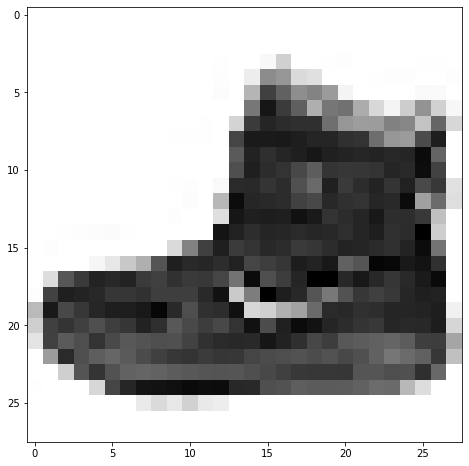

In [3]:
# getting an image and the corresponding label
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
sample_index = 0
num_labels = len(label_names)
image = train_dataset[sample_index][0]
label = label_names[train_dataset[sample_index][1]]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")
print(f"Label index: {train_dataset[sample_index][1]}")

# convert the image to a numpy array
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

# convert the image to a torch tensor
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

## Data transformation

In [4]:
train_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Train / Validation split

In [5]:
#divide the train_dataset in train and validation sets (10% of the dataset)
train_ds, validation_ds = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_ds = test_dataset #change name, just aesthetic

## Dataloader

In [6]:
# Define train dataloader
train_dataloader = DataLoader(train_ds, batch_size=256, shuffle=False) # shuffle=True

# Define validation dataloader
validation_dataloader = DataLoader(validation_ds, batch_size=256, shuffle=False) # shuffle=True

# Define test dataloader
test_dataloader = DataLoader(test_ds, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f'Train dataloader size: {len(train_dataloader)}')
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(validation_dataloader))
print(f"VALIDATION BATCH SHAPE")
print(f'Validation dataloader size: {len(validation_dataloader)}')
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f'Test dataloader size: {len(test_dataloader)}')
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
Train dataloader size: 196
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
VALIDATION BATCH SHAPE
Validation dataloader size: 40
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
Test dataloader size: 40
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


## Convolutional Network

In [7]:
#good convolutinal neural network architecture, 88% accuracy with 150 epochs, v1
class myCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=6, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Second convolutional layer
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=12*4*4, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=32, out_features=10),
            nn.ReLU(True),

            # we don't need softmax since we'll use cross entropy loss
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.conv(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.lin(x)
        return x

In [8]:
#set seed
torch.manual_seed(42)

# Instantiate the model
cnn = myCNN()

## Training

In [9]:
# define the loss function
loss_fn = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#move the model to the selected device
cnn.to(device)

Selected device: cuda


myCNN(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=10, bias=True)
    (7): ReLU(inplace=True)
  )
)

In [10]:
# Training function
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    # Set the model to training mode
    model.train()
    # Initialize the loss
    running_loss = 0
    train_loss = []
    # Loop over the training batches
    for (data, label) in tqdm(dataloader):
        # target = onehot encoding of label
        target = torch.eye(10)[label] 
        # Move the input and target data to the selected device
        data, target = data.to(device), target.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute the output
        output = model(data)
        assert output.shape == target.shape
        # Compute the loss
        loss = loss_fn(output, target)
        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        #batch loss
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    # Return the average training loss
    train_loss = np.mean(train_loss)
    print(f"Training loss: {train_loss}")
    return train_loss

#validation function
def validate_epoch(model, dataloader, loss_fn, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the validation loss
    val_loss = []
    # Loop over the validation batches
    with torch.no_grad():
        for (data, label) in tqdm(dataloader):
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # Compute the output
            output = model(data)
            assert output.shape == target.shape
            # Compute the loss
            loss = loss_fn(output, target)
            #batch loss
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    # Return the average validation loss
    val_loss = np.mean(val_loss)
    print(f"Validation loss: {val_loss}")
    return val_loss

# Training loop

In [11]:
# decide to train or not
load_good_model = True # if True do not train a new model, if False train a new model
good_model_path = "good_models/cnn_v1_epoch_10.pth"

In [12]:
#create a folder called training to save the model
import pickle
if not load_good_model:
    if not os.path.exists('training'):
        os.makedirs('training')
    #clear the training folder
    if os.listdir('training'):
        for f in os.listdir('training'):
            os.remove(os.path.join('training', f))

In [13]:
# training loop
if not load_good_model:
    num_epochs = 10 #150
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        # Train the model
        train_loss = train_epoch(cnn, train_dataloader, loss_fn, optimizer, device)
        # Validate the model
        val_loss = validate_epoch(cnn, validation_dataloader, loss_fn, device)
        # Append the losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save network parameters
        torch.save(cnn.state_dict(), f"training/cnn_epoch_{epoch+1}.pth")
    
    # Save the losses
    with open('training/losses.pkl', 'wb') as f:
        pickle.dump([train_losses, val_losses], f)
else:
    #load the model
    cnn.load_state_dict(torch.load(good_model_path))
    #load the losses
    with open('good_models/losses.pkl', 'rb') as f:
        train_losses, val_losses = pickle.load(f)
    #validate the model
    val_loss = validate_epoch(cnn, validation_dataloader, loss_fn, device)
    #test the model
    test_loss = validate_epoch(cnn, test_dataloader, loss_fn, device)

100%|██████████| 40/40 [00:01<00:00, 23.04it/s]


Validation loss: 0.48518699407577515


100%|██████████| 40/40 [00:01<00:00, 20.78it/s]

Validation loss: 0.5003390908241272


## Losses and model accuracy

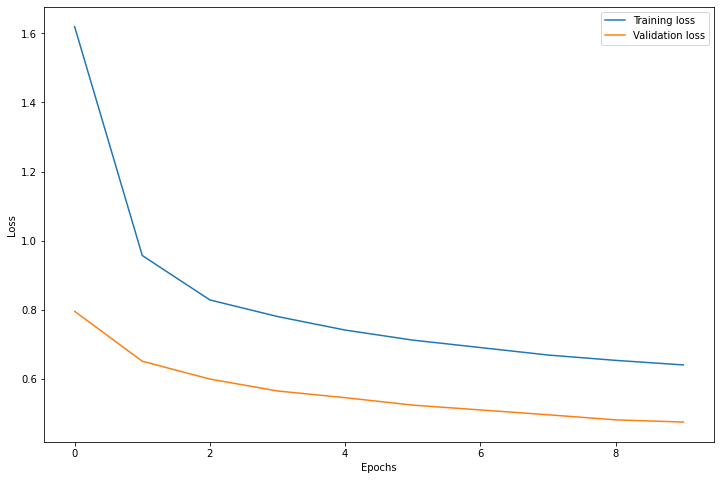

In [14]:
# Plot the training and validation losses
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train_losses, label='Training loss')
ax.plot(val_losses, label='Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [15]:
# Evaluate the model on the test set
test_loss = validate_epoch(cnn, test_dataloader, loss_fn, device)
print(f"Test loss: {test_loss}")

100%|██████████| 40/40 [00:01<00:00, 21.41it/s]

Validation loss: 0.5003390908241272
Test loss: 0.5003390908241272


In [16]:
#get the percentage of correct predictions on the test set
correct = 0
total = 0
with torch.no_grad():
    for (data, label) in test_dataloader:
        # Move the input and target data to the selected device
        data, label = data.to(device), label.to(device)
        # Compute the output
        output = cnn(data)
        # Compute the loss
        loss = loss_fn(output, label)
        # Get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        # Add to the total number of correct predictions
        correct += pred.eq(label.view_as(pred)).sum().item()
        # Add to the total number of predictions
        total += data.shape[0]

# Calculate the accuracy
accuracy = correct/total
print(f"Test accuracy: {accuracy}")


Test accuracy: 0.8029


## Confusion Matrices

In [17]:
# function to get all predictions
def get_predictions(model, dataloader, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the predictions
    predictions = []
    # Loop over the test batches
    with torch.no_grad():
        for (data, label) in tqdm(dataloader):
            # Move the input and target data to the selected device
            data, label = data.to(device), label.to(device)
            # Compute the output
            output = model(data)
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Add to the predictions
            predictions.extend(pred.cpu().numpy().tolist())
    return predictions

#get train dataset predictions
train_predictions = get_predictions(cnn, train_dataloader, device)
# get test dataset predictions
test_predictions = get_predictions(cnn, test_dataloader, device)

#get the labels
train_labels = []
for data, label in tqdm(train_dataloader): #note: to have a reasonable cm, dataloader needs to be without shuffle
    train_labels.extend(label.numpy())

test_labels = []
for data, label in tqdm(test_dataloader):
    test_labels.extend(label.numpy())

print(f"Train labels: {train_labels[:10]}")
print(f"Train predictions: {train_predictions[:10]}")
print(f"Test labels: {test_labels[:10]}")
print(f"Test predictions: {test_predictions[:10]}")

# calculate confusion matrix for train and test set 
import sklearn.metrics as metrics
cm_train = metrics.confusion_matrix(train_labels, train_predictions)
cm_test = metrics.confusion_matrix(test_labels, test_predictions)

100%|██████████| 40/40 [00:01<00:00, 25.76it/s]


Train labels: [1, 9, 3, 2, 7, 5, 0, 7, 7, 3]
Train predictions: [[1], [9], [3], [2], [7], [5], [0], [7], [7], [3]]
Test labels: [9, 2, 1, 1, 6, 1, 4, 6, 5, 7]
Test predictions: [[9], [2], [1], [1], [2], [1], [4], [4], [5], [7]]


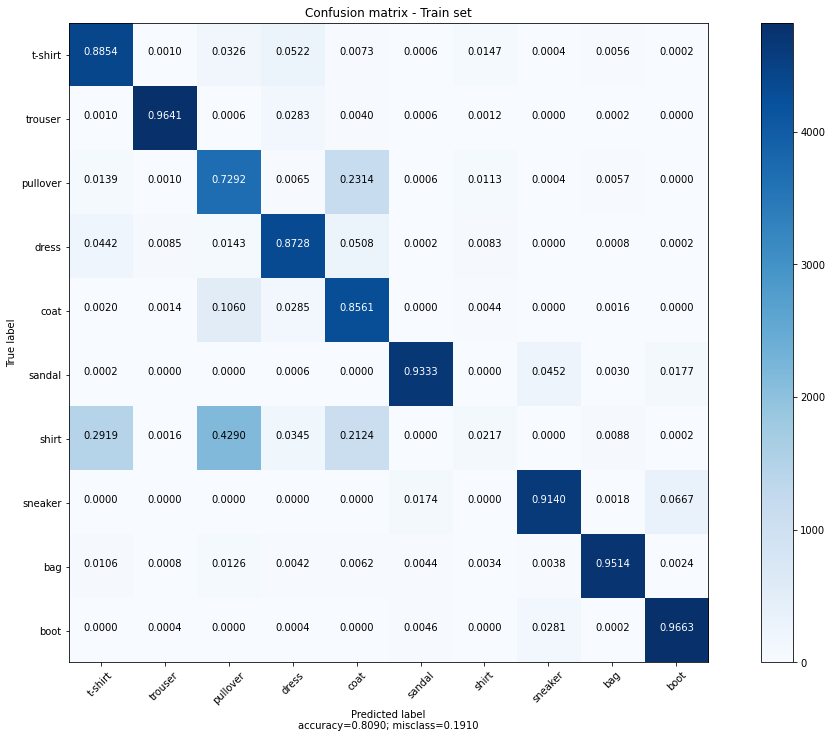

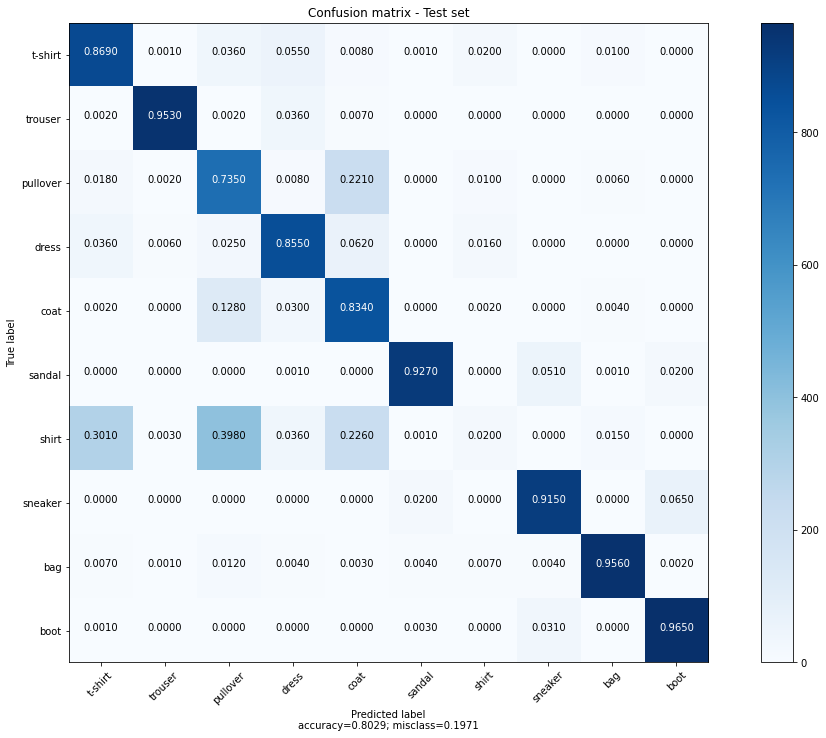

In [18]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cm_train, target_names=label_names, title='Confusion matrix - Train set')
plot_confusion_matrix(cm_test, target_names=label_names, title='Confusion matrix - Test set')

## Activations